In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import sparse
from pprint import pprint
from datetime import datetime,timedelta
import matplotlib.pyplot as plt

import os
import json

#sklearn 
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.metrics import r2_score, mean_squared_error, classification_report,confusion_matrix, roc_curve, auc

#Snowflake
import sqlalchemy
import sqlalchemy.dialects.sqlite
from snowflake.sqlalchemy import URL

from IPython.display import display, HTML, Image
from subprocess import call
import gc

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

In [8]:
50 % 25

0

In [3]:
config_file = os.path.join(os.environ['HOME'], '.snowflake_creds.json')
with open(config_file,'r') as f:
    snowflake_creds = json.load(f)

engine = sqlalchemy.create_engine(
     URL(
         account = snowflake_creds["account"],
         user = snowflake_creds["user"],
         password = snowflake_creds["password"],
         database = snowflake_creds["database"],
         schema = 'aib',
         warehouse = 'DS',
         role = 'DS',
         numpy=True             
     )
)
connection = engine.connect()

# Functions

In [4]:
class ColumnSelector(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols

    def transform(self, X, y=None):
        return X[self.cols]

    def fit(self, X, y=None):
        return self

    def get_feature_names(self):
        return X[self.cols].columns.tolist()

class CategoricalColumnSelector(TransformerMixin):
    def __init__(self,feats):
        self.feats = feats

    def transform(self, X, y=None):
        regstr = ''
        length = len(self.feats)
        for i,feat in enumerate(self.feats):
            regstr = regstr+'^'+feat+'_+'

            if i < length-1:
                regstr = regstr+'|'
        return X.filter(regex=regstr)

    def fit(self, X, y=None):
        return self

    def get_feature_names(self):
        return X[self.cols].columns.tolist()

class ToSparse(TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, y=None):
        return sparse.csr_matrix(X)

    def fit(self, X, y=None):
        return self


In [5]:
def best_params(grid):
    estimator = grid.best_estimator_
    pca = grid.best_estimator_.steps[1][1]
    classifier = grid.best_estimator_.steps[2][1]
    params = grid.best_params_
    score = grid.best_score_
    return estimator,pca,classifier,params,score

# Get Users

In [6]:
sql = """
WITH deploy_ar AS
(
  SELECT send_timestamp::DATE AS send_date,
         email,
         isp
  FROM reporting.autoresponder_engagement
  WHERE DEPLOY_ID LIKE '1FRWISK2514191106'
),
clicks AS
(
  SELECT click::DATE AS click_date,
         email,
         isp,
         COUNT(*) clicks
  FROM aib.clicks
  WHERE click::DATE BETWEEN '2019-01-01' AND CURRENT_DATE -1
  GROUP BY 1,
           2,
           3
),
year_clicks AS
(
  SELECT send_date,
         t1.email,
         t1.isp,
         SUM(clicks) OVER (
         PARTITION BY t1.email,t1.isp,send_date
         ORDER BY click_date 
         ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_clicks
  FROM deploy_ar AS t1
    LEFT JOIN clicks AS t2
           ON t1.email = t2.email
          AND t1.isp = t2.isp
          AND t2.click_date <= send_date
),
opens AS
(
  SELECT opendt::DATE AS open_date,
         email,
         isp,
         COUNT(*) AS opens
  FROM aib.opens
  WHERE opendt::DATE BETWEEN '2019-01-01' AND CURRENT_DATE -1
  GROUP BY 1,
           2,
           3
),
year_opens AS
(
  SELECT send_date,
         t1.email,
         t1.isp,
         SUM(opens) OVER (
         PARTITION BY t1.email,t1.isp,send_date
         ORDER BY open_date 
         ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_opens
  FROM deploy_ar as t1
    LEFT JOIN opens AS t2
           ON t1.email = t2.email
          AND t1.isp = t2.isp
          AND t2.open_date <= send_date
),
traverse AS
(
  SELECT traverse_ts::DATE AS traverse_date,
         email,
         COUNT(*) traverse_signal,
         SUM(CASE WHEN CONTAINS(split_part (category,'/',2),'education') THEN 1 ELSE 0 END) AS education_signal
  FROM ds_scratch.traverse_feature_collection
  WHERE traverse_ts::DATE BETWEEN '2019-01-01' AND CURRENT_DATE -1
  GROUP BY 1,
           2
),
year_signals AS
(
  SELECT send_date,
         traverse_date,
         t1.email,
         isp,
         SUM(traverse_signal) OVER (
         PARTITION BY t1.email,isp,send_date
         ORDER BY traverse_date 
         ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_signals,
         SUM(education_signal) OVER (
         PARTITION BY t1.email,isp,send_date 
         ORDER BY traverse_date 
         ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS education_signals
  FROM deploy_ar AS t1
    JOIN traverse AS t2
      ON t1.email = t2.email
     AND t2.traverse_date <= send_date
),
deploy_stats AS
(
  SELECT DEPLOY_ID,
         SUM(NVL (INTERNAL_CLICKS,0) + NVL (AR_CLICKS,0)) AS clicks,
         SUM(NVL (REVENUE,0)) AS revenue
  FROM DS_PROD.SOURCE_CUBE
  GROUP BY 1
),
epc AS
(
  SELECT DEPLOY_ID,
         revenue / clicks AS epc
  FROM deploy_stats
  WHERE clicks != 0
),
L30_sends AS
(
  SELECT TRIM(JSON:email,'"') AS email,
         TRIM(JSON:isp,'"') AS isp,
         COUNT(*) AS L30_sends
  FROM aib.sends
  WHERE TIMESTAMP_REC::DATE BETWEEN CURRENT_DATE -31 AND CURRENT_DATE -1
  GROUP BY 1,
           2
),
L30_clicks AS
(
  SELECT email,
         isp,
         deploy_id,
         COUNT(*) AS L30_clicks
  FROM aib.clicks
  WHERE click::DATE BETWEEN CURRENT_DATE -31 AND CURRENT_DATE -1
  GROUP BY 1,
           2,
           3
),
revenue AS
(
  SELECT email,
         isp,
         SUM(L30_clicks*epc) AS l30_revenue
  FROM L30_clicks
    JOIN epc USING (deploy_id)
  GROUP BY 1,
           2
),
click_stats AS
(
  SELECT send_date,
         email,
         isp,
         MAX(total_clicks) AS clicks_to_date
  FROM year_clicks
  GROUP BY 1,
           2,
           3
),
open_stats AS
(
  SELECT send_date,
         email,
         isp,
         MAX(total_opens) AS opens_to_date
  FROM year_opens
  GROUP BY 1,
           2,
           3
),
traverse_stats AS
(
  SELECT send_date,
         email,
         isp,
         MAX(total_signals) AS signals_to_date,
         MAX(education_signals) AS edu_signals_to_date
  FROM year_signals
  GROUP BY 1,
           2,
           3
),
initial AS
(
  SELECT send_date,
         email,
         isp,
         clicks_to_date,
         opens_to_date,
         signals_to_date,
         edu_signals_to_date,
         l30_revenue,
         L30_sends,
         L30_revenue*1000.0 / L30_sends AS ecpm
  FROM deploy_ar
    LEFT JOIN click_stats USING (send_date,email,isp)
    LEFT JOIN open_stats USING (send_date,email,isp)
    LEFT JOIN traverse_stats USING (send_date,email,isp)
    LEFT JOIN l30_sends USING (email,isp)
    LEFT JOIN revenue USING (email,isp)
  WHERE L30_sends IS NOT NULL
  AND   L30_sends != 0
),
first_names AS
(
  SELECT DISTINCT email,
         FIRST_VALUE(first_name) IGNORE NULLS OVER (PARTITION BY email ORDER BY timestamp_rec DESC) AS first_name
  FROM aib.signup_actives
    JOIN DS_SCRATCH.recommender_targets USING (email)
)
SELECT send_date,
       email,
       first_name,
       isp,
       clicks_to_date,
       opens_to_date,
       signals_to_date,
       edu_signals_to_date,
       l30_revenue,
       L30_sends,
       ecpm
FROM initial as t1
  JOIN first_names USING (email)
WHERE send_date = (
select max(send_date) 
from initial as t2 
where t1.email = t2.email and t1.isp = t2.isp)
LIMIT 100000;
"""
DF = pd.read_sql_query(sql,engine)
#DF.dropna(thresh=3,inplace=True)
DF.fillna(0,inplace=True)

In [7]:
DF.shape

(1002, 11)

In [8]:
DF.head()


,send_date,email,first_name,isp,clicks_to_date,opens_to_date,signals_to_date,edu_signals_to_date,l30_revenue,l30_sends,ecpm
0,2019-12-19,cindyisabelmedina@gmail.com,Cynthia,gmail,57.0,39.0,4.0,0.0,2.750085,178,15.449918
1,2019-12-16,elizabethschuchmann33@gmail.com,Elizabeth,gmail,139.0,164.0,12.0,0.0,27.070997,1236,21.902101
2,2019-12-18,sassytammy1964@gmail.com,Tamara,gmail,1013.0,1015.0,20.0,0.0,16.068522,1981,8.111319
3,2019-12-18,vcubellis@yahoo.com,Victor,yahoo,1749.0,1433.0,480.0,6.0,17.432309,1143,15.251364
4,2019-12-11,anissalori@gmail.com,Anissa,gmail,108.0,31.0,50.0,0.0,3.571157,61,58.543555


In [9]:
#change send date to today
DF.send_date = datetime.today().date()

categorical = ['isp','send_date']
numerical = ['clicks_to_date',
             'opens_to_date',
             'signals_to_date',
             'edu_signals_to_date']
features = categorical + numerical

In [10]:
X = DF[features]
y = DF['ecpm']

# Load Model

In [35]:
gs_dt = pickle.load(open('edu_model_v1.pkl', 'rb'))

In [12]:
def RegModelEval(DF,n=100,show=False,output='none'):
    df = DF.sample(n=n)
    y = df[output]
    y_pred = df.pred_out
    print('R^2 Test: {:.5f}'.format(r2_score(y,y_pred)))
    print('MSE Test: {:.5f}'.format(mean_squared_error(y,y_pred)))

    if show:
        plt.rcParams['figure.figsize'] = (8, 8)
        plt.scatter(y_pred[:n],(y_pred[:n]-y[:n]),c='lightgreen',marker='s',label='Test_data')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.legend(loc='upper left')
        #plt.hlines(y=0,xmin=-10,xmax=10,color='red',lw=2,linestyle='-')
        #plt.xlim([-1,1])
        plt.show()

In [36]:
output = 'ecpm'
pred = gs_dt.predict(X)
pred_df = pd.DataFrame(list(zip(X.index,pred)),columns=['id','pred_out'])
eval_df = pred_df.merge(DF[features+[output]],right_index=True,left_on='id')

In [14]:
eval_df.head()

,id,pred_out,isp,send_date,clicks_to_date,opens_to_date,signals_to_date,edu_signals_to_date,ecpm
0,0,20.132127,gmail,2019-12-19,57.0,39.0,4.0,0.0,15.449918
1,1,13.729487,gmail,2019-12-19,139.0,164.0,12.0,0.0,21.902101
2,2,10.421337,gmail,2019-12-19,1013.0,1015.0,20.0,0.0,8.111319
3,3,85.919433,yahoo,2019-12-19,1749.0,1433.0,480.0,6.0,15.251364
4,4,31.122388,gmail,2019-12-19,108.0,31.0,50.0,0.0,58.543555


R^2 Test: -0.52762
MSE Test: 160.20326


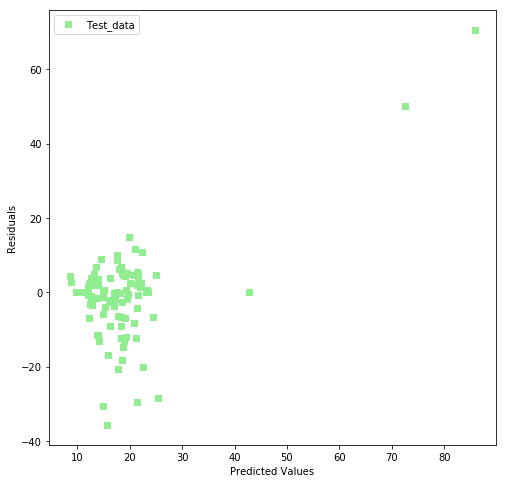

In [15]:
RegModelEval(eval_df,show=True,output=output)

# Finding Users

In [16]:
sort_df = eval_df.sort_values('pred_out', ascending=False)

In [17]:
sort_df.head()

,id,pred_out,isp,send_date,clicks_to_date,opens_to_date,signals_to_date,edu_signals_to_date,ecpm
737,737,582.827696,yahoo,2019-12-19,1167.0,844.0,2.0,0.0,603.882391
230,230,123.529187,yahoo,2019-12-19,1068.0,851.0,61.0,0.0,203.035382
954,954,115.014823,yahoo,2019-12-19,294.0,138.0,28.0,3.0,159.075771
447,447,103.900866,yahoo,2019-12-19,3491.0,2116.0,741.0,0.0,31.728062
490,490,96.326394,yahoo,2019-12-19,837.0,782.0,138.0,0.0,118.143581


In [32]:
#get top 20% of users
cols = ['email','first_name','pred_out','ecpm']
ids = sort_df.head(int(sort_df.shape[0]*.2)).id.tolist()
predicted_outs = sort_df.head(int(sort_df.shape[0]*.2))[['id','pred_out','ecpm']]
top_users_selected = DF.iloc[ids][['email','first_name']]
final_table = top_users_selected.merge(predicted_outs,right_on='id',left_index=True)
final_table = final_table[cols]
final_table['upload_time']  = datetime.now()

In [33]:
final_table.head()

,email,first_name,pred_out,ecpm,upload_time
737,lisettekidson@yahoo.com,Lisette,582.827696,603.882391,2019-12-19 16:37:04.099828
230,mdcjsmith41041@yahoo.com,James,123.529187,203.035382,2019-12-19 16:37:04.099828
954,cameronjv1955@yahoo.com,Jamie,115.014823,159.075771,2019-12-19 16:37:04.099828
447,singleannief65@yahoo.com,Deborah,103.900866,31.728062,2019-12-19 16:37:04.099828
490,ltbav@yahoo.com,ben,96.326394,118.143581,2019-12-19 16:37:04.099828


In [18]:
#id_list = sort_df.loc[(sort_df.difference > 0) & (sort_df.difference < 5)].id.tolist()
#sort_df.loc[(sort_df.difference > 0) & (sort_df.difference < 5)].head()

In [40]:
#emails = DF.iloc[id_list].email.tolist()

In [24]:
#emails

# write to table

In [34]:
final_table.to_sql('user_select_edu_final_alex',
                   connection,
                   schema = 'ds_scratch',
                   if_exists='replace',
                   index=False,
                   chunksize=10000)
connection.execute('Grant all privileges ON ds_scratch.user_select_edu_final_alex TO PUBLIC')